**Data Inspection, Cleaning and Preparation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Import the necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import numpy as np
import os

In [3]:
def df_check(df_to_check):
    """Function to generate information for a data frame"""
    # Generate a summary for NaN, zero and unique values
    nan_count = df_to_check.isna().sum()
    unique_count = df_to_check.nunique()
    zero_count = (df_to_check == 0).sum()
    data_type = df_to_check.dtypes

    # Merge the summaries into one dataframe for inspection
    df_check = pd.concat([nan_count,unique_count, zero_count, data_type],axis =1)
    df_check.columns = ['NaN Count','Unique Count','Zero Count', 'Data Type']
    print(df_check)


In [122]:
# Load the demand, forecast and temperature data
os.chdir('/content/drive/MyDrive/data/Group10_project')

forecast_demand_df = pd.read_csv(
    'data/NSW/forecastdemand_nsw.csv',
    sep=',',
    header=0,
    dtype={'PREDISPATCHSEQNO': str, 'PERIODID': int, 'FORECASTDEMAND': float},
    parse_dates=['LASTCHANGED', 'DATETIME']
)

# Load the temperature data
temperature_df = pd.read_csv('data/NSW/temperature_nsw.csv', sep=',', header=0)


# Load the total demand data
total_demand_df = pd.read_csv('data/NSW/totaldemand_nsw.csv', sep=',', header=0,
                              parse_dates=['DATETIME'],
                              dtype={'TOTALDEMAND': float,'REGIONID': str}
                              )


In [43]:
# Load the wildfiredata
os.chdir('/content/drive/MyDrive/data/Group10_project')
wildfire_df = pd.read_csv('data/NSW/NSW_fire_history_wildfire.xls', sep=',', header=0, parse_dates=['StartDate','EndDate'],)
wildfire_df.head()

,FID,FireName,FireNo,Label,StartDate,EndDate,AreaHa,PerimeterM,Verdate,Type,Season,ID,Year,Year_Con,Shape__Area,Shape__Length,Days
0,1,,,1968-69 Prescribed Burn,1968-10-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,2.184770,1548.960666,26/03/2020,Prescribed Burn,1968-69,0,1968,1968/01/01 00:00:00+00,2.186876e+04,1549.703956,NaN
1,2,,,1970-71 Prescribed Burn,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,299.985464,8615.637120,26/03/2020,Prescribed Burn,1970-71,1,1970,1970/01/01 00:00:00+00,2.996520e+06,8610.851395,NaN
2,3,,70/161,1970-71 Prescribed Burn,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,309.025645,20657.633990,26/03/2020,Prescribed Burn,1970-71,2,1970,1970/01/01 00:00:00+00,3.085906e+06,20643.091300,NaN
3,4,,70/161,1970-71 Prescribed Burn,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,316.104427,20353.231750,26/03/2020,Prescribed Burn,1970-71,3,1970,1970/01/01 00:00:00+00,3.156677e+06,20339.165560,NaN
4,5,,70/160,1970-71 Prescribed Burn,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,28.484088,2695.160793,26/03/2020,Prescribed Burn,1970-71,4,1970,1970/01/01 00:00:00+00,2.844296e+05,2693.214793,NaN


In [123]:
df_check(forecast_demand_df)
print(f'Total records in forecast_demand_df: {len(forecast_demand_df)}')

                  NaN Count  Unique Count  Zero Count       Data Type
PREDISPATCHSEQNO          0        196571           0          object
REGIONID                  0             1           0          object
PERIODID                  0            79           0           int64
FORECASTDEMAND            0        681384           0         float64
LASTCHANGED               0        196571           0  datetime64[ns]
DATETIME                  0        196513           0  datetime64[ns]
Total records in forecast_demand_df: 10906019


In [124]:
forecast_demand_df.head()

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
0,2009123018,NSW1,71,7832.04,2009-12-30 12:31:49,2010-01-01
1,2009123019,NSW1,70,7832.04,2009-12-30 13:01:43,2010-01-01
2,2009123020,NSW1,69,7832.03,2009-12-30 13:31:36,2010-01-01
3,2009123021,NSW1,68,7832.03,2009-12-30 14:01:44,2010-01-01
4,2009123022,NSW1,67,7830.96,2009-12-30 14:31:35,2010-01-01


In [125]:
# Group by 'DATETIME' and find the maximum 'PERIODID' for each group
max_periodid_df = forecast_demand_df.loc[forecast_demand_df.groupby('DATETIME')['PERIODID'].idxmax()]

# Assign the result back to the original DataFrame
forecast_demand_df = max_periodid_df


In [126]:
df_check(forecast_demand_df)
print(f'Total records in forecast_demand_df: {len(forecast_demand_df)}')

                  NaN Count  Unique Count  Zero Count       Data Type
PREDISPATCHSEQNO          0          4095           0          object
REGIONID                  0             1           0          object
PERIODID                  0            48           0           int64
FORECASTDEMAND            0        160758           0         float64
LASTCHANGED               0          4095           0  datetime64[ns]
DATETIME                  0        196513           0  datetime64[ns]
Total records in forecast_demand_df: 196513


In [127]:
df_check(total_demand_df)
print(f'Total records in total_demand_df: {len(total_demand_df)}')

             NaN Count  Unique Count  Zero Count Data Type
DATETIME             0        196513           0    object
TOTALDEMAND          0        160515           0   float64
REGIONID             0             1           0    object
Total records in total_demand_df: 196513


In [128]:
total_demand_df.head()

,DATETIME,TOTALDEMAND,REGIONID
0,1/1/2010 0:00,8038.00,NSW1
1,1/1/2010 0:30,7809.31,NSW1
2,1/1/2010 1:00,7483.69,NSW1
3,1/1/2010 1:30,7117.23,NSW1
4,1/1/2010 2:00,6812.03,NSW1


In [129]:
df_check(temperature_df)
print(f'Total records in temperature_df: {len(temperature_df)}')

             NaN Count  Unique Count  Zero Count Data Type
LOCATION             0             1           0    object
DATETIME             0        220313           0    object
TEMPERATURE          0           439           0   float64
Total records in temperature_df: 220326


In [130]:
temperature_df.tail()

,LOCATION,DATETIME,TEMPERATURE
220321,Bankstown,17/3/2021 23:00,19.1
220322,Bankstown,17/3/2021 23:20,19.0
220323,Bankstown,17/3/2021 23:30,18.8
220324,Bankstown,17/3/2021 23:34,18.8
220325,Bankstown,18/3/2021 0:00,18.6


In [131]:
# Convert 'DATETIME' column to datetime objects
temperature_df['DATETIME'] = pd.to_datetime(temperature_df['DATETIME'], format='%d/%m/%Y %H:%M')
forecast_demand_df['DATETIME'] = pd.to_datetime(forecast_demand_df['DATETIME'])
total_demand_df['DATETIME'] = pd.to_datetime(total_demand_df['DATETIME'], format='%d/%m/%Y %H:%M')

In [140]:
# Merging the temperature and forecast demand dataframes
merged_df = pd.merge(
    temperature_df[['DATETIME', 'TEMPERATURE']],
    forecast_demand_df[['DATETIME', 'FORECASTDEMAND']],
    on='DATETIME'
)

# Merging the result with the total demand dataframe
final_df = pd.merge(
    merged_df,
    total_demand_df[['DATETIME', 'TOTALDEMAND']],
    on='DATETIME'
)

# Displaying the first few rows of the final merged dataframe
final_df.head()


,DATETIME,TEMPERATURE,FORECASTDEMAND,TOTALDEMAND
0,2010-01-01 00:00:00,23.1,7832.04,8038.00
1,2010-01-01 00:30:00,22.9,7725.11,7809.31
2,2010-01-01 01:00:00,22.6,7487.61,7483.69
3,2010-01-01 01:30:00,22.5,7136.08,7117.23
4,2010-01-01 02:00:00,22.5,6801.07,6812.03


In [141]:

merged_df = final_df


In [148]:

merged_df.set_index('DATETIME', inplace=True)


In [149]:
# Create a 'Season' column
# Extract Year and Season from DATETIME
merged_df['Year'] = merged_df['DATETIME'].dt.year # Access the year using .dt.year
merged_df['Month'] = merged_df['DATETIME'].dt.month # Access the month using .dt.month

def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Summer'
    elif date.month in [3, 4, 5]:
        return 'Autumn'
    elif date.month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

merged_df['Season'] = merged_df['DATETIME'].apply(get_season)


KeyError: 'DATETIME'

In [150]:
merged_df.head()

,TEMPERATURE,FORECASTDEMAND,TOTALDEMAND,Year,Month,Season
DATETIME,,,,,,
2010-01-01 00:00:00,23.1,7832.04,8038.00,2010,1,Summer
2010-01-01 00:30:00,22.9,7725.11,7809.31,2010,1,Summer
2010-01-01 01:00:00,22.6,7487.61,7483.69,2010,1,Summer
2010-01-01 01:30:00,22.5,7136.08,7117.23,2010,1,Summer
2010-01-01 02:00:00,22.5,6801.07,6812.03,2010,1,Summer


In [151]:
# Statistical Summary
summary_stats = merged_df.describe()

In [152]:
summary_stats

,TEMPERATURE,FORECASTDEMAND,TOTALDEMAND,Year,Month
count,195947.000000,195947.000000,195947.000000,195947.000000,195947.000000
mean,17.530995,8104.312148,8111.924589,2015.118532,6.437108
std,5.884212,1309.325007,1299.171401,3.234419,3.479312
min,-1.300000,4426.580000,5074.630000,2010.000000,1.000000
25%,13.500000,7119.620000,7149.430000,2012.000000,3.000000
50%,17.900000,8057.660000,8052.180000,2015.000000,6.000000
75%,21.500000,8969.385000,8956.985000,2018.000000,9.000000
max,44.700000,14584.820000,14579.860000,2021.000000,12.000000


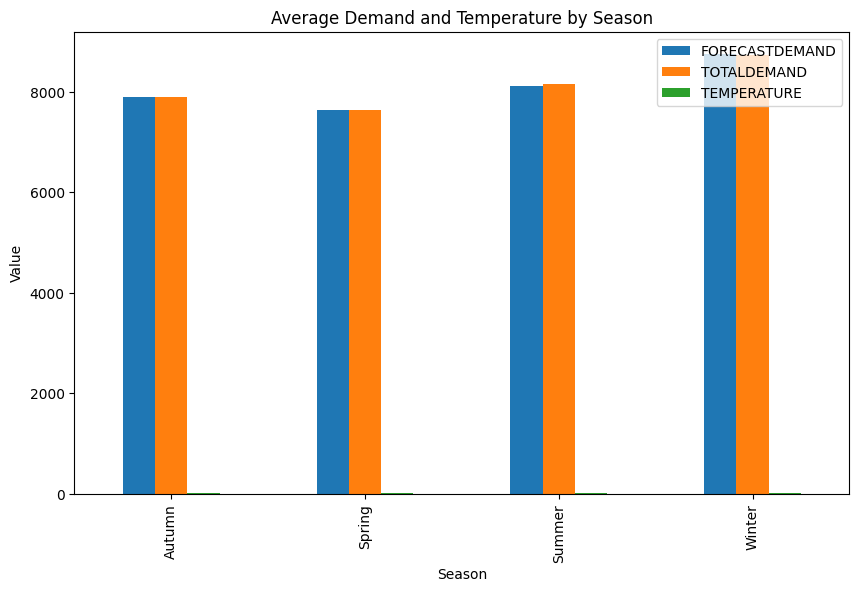

In [153]:
# Seasonal Analysis - Group by season and visualize average demand and temperature
seasonal_means = merged_df.groupby('Season').mean()

# Plot seasonal means for total and forecast demand, and temperature
seasonal_means[['FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE']].plot(kind='bar', figsize=(10, 6))
plt.title('Average Demand and Temperature by Season')
plt.ylabel('Value')
plt.show()

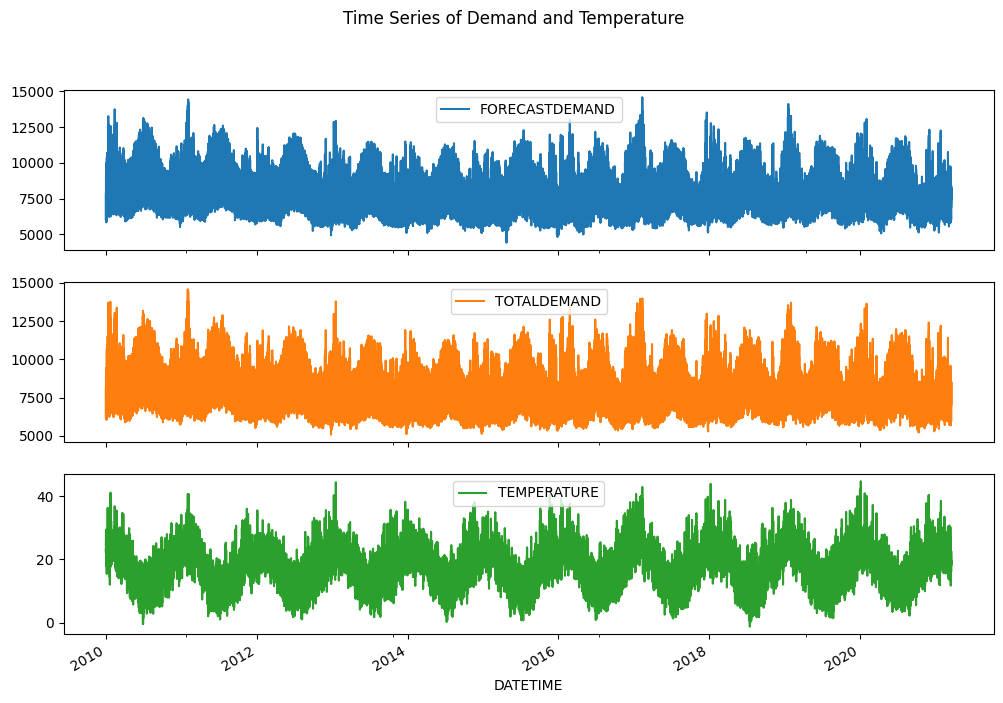

In [154]:
#  Trend Analysis - Plot time series of demand and temperature
merged_df[['FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE']].plot(subplots=True, figsize=(12, 8), title='Time Series of Demand and Temperature')
plt.show()

In [155]:
# 4. Correlation Analysis
corr_matrix = merged_df[['FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE']].corr()

In [156]:
corr_matrix

,FORECASTDEMAND,TOTALDEMAND,TEMPERATURE
FORECASTDEMAND,1.000000,0.981781,0.140470
TOTALDEMAND,0.981781,1.000000,0.149045
TEMPERATURE,0.140470,0.149045,1.000000


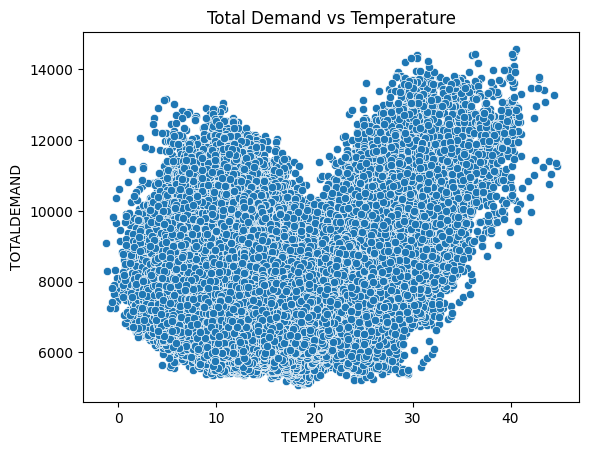

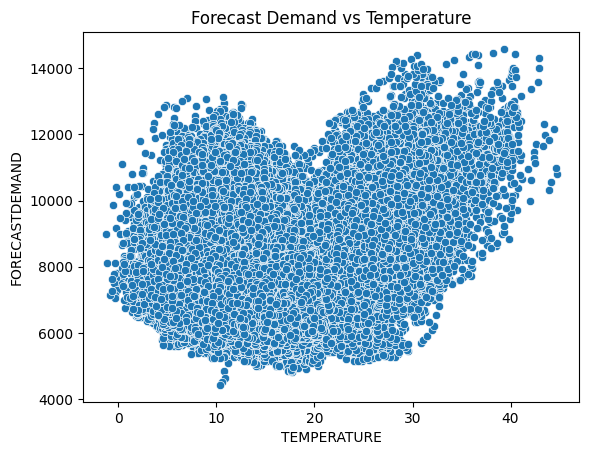

In [157]:
# 5. Scatter plot for demand vs. temperature
sns.scatterplot(data=merged_df, x='TEMPERATURE', y='TOTALDEMAND')
plt.title('Total Demand vs Temperature')
plt.show()

sns.scatterplot(data=merged_df, x='TEMPERATURE', y='FORECASTDEMAND')
plt.title('Forecast Demand vs Temperature')
plt.show()

In [158]:
# 6. Time-lagged analysis (shifting temperature data by a day)
merged_df['Temp_Lag_1D'] = merged_df['TEMPERATURE'].shift(1)
lag_corr = merged_df[['TOTALDEMAND', 'Temp_Lag_1D']].corr()

In [159]:
lag_corr

,TOTALDEMAND,Temp_Lag_1D
TOTALDEMAND,1.0000,0.1514
Temp_Lag_1D,0.1514,1.0000


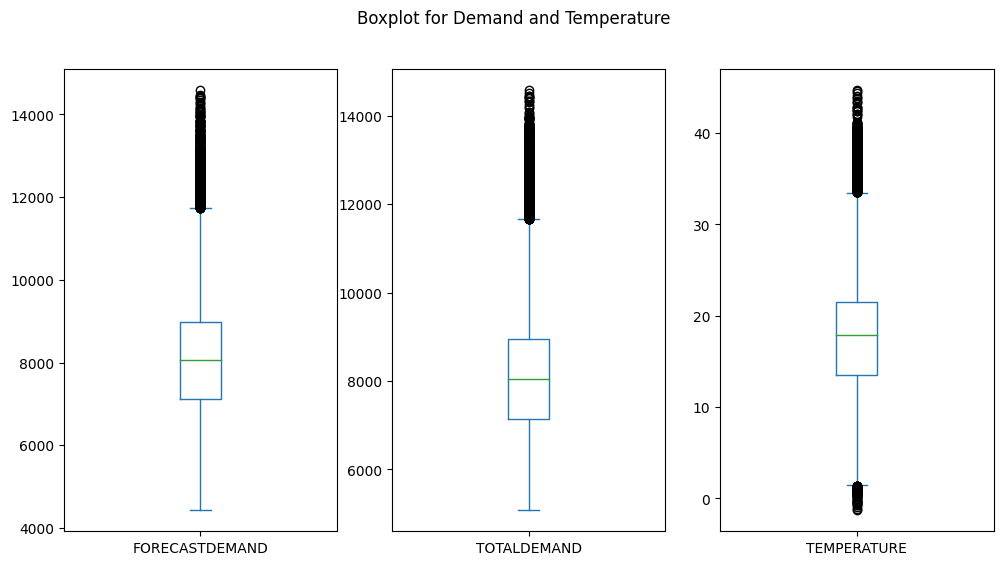

In [160]:
#  Outlier Detection - Boxplot for temperature and demand
merged_df[['FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE']].plot(kind='box', subplots=True, layout=(1,3), figsize=(12, 6), title='Boxplot for Demand and Temperature')
plt.show()

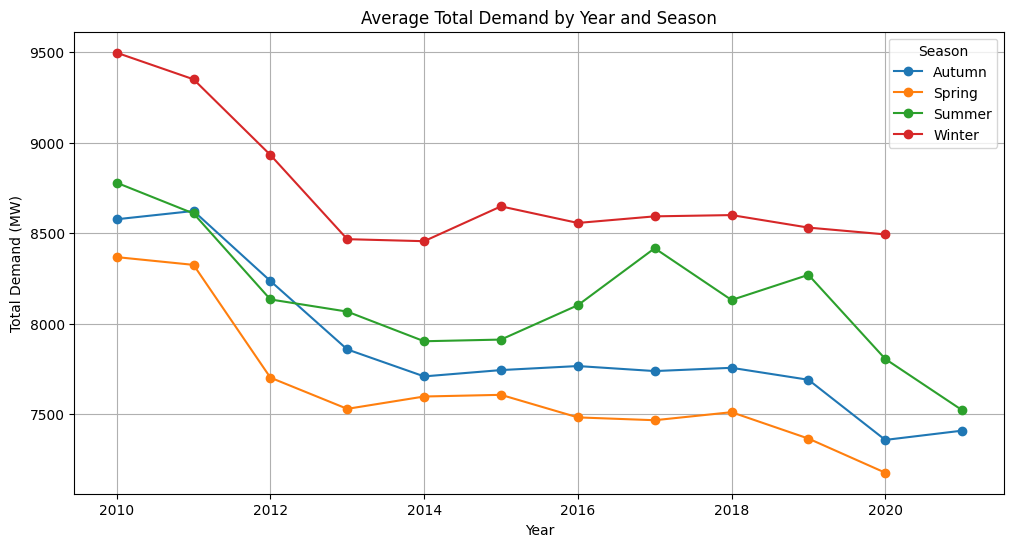

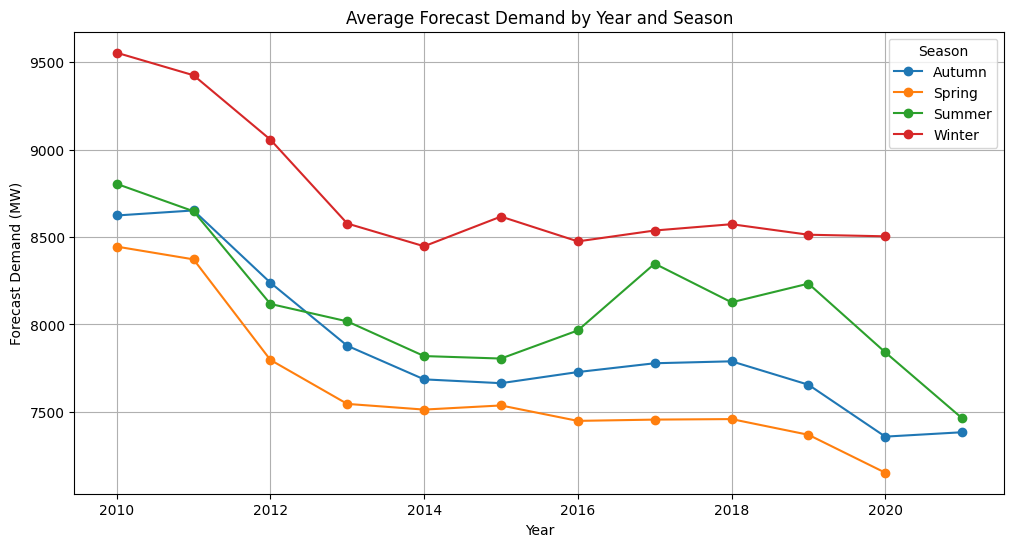

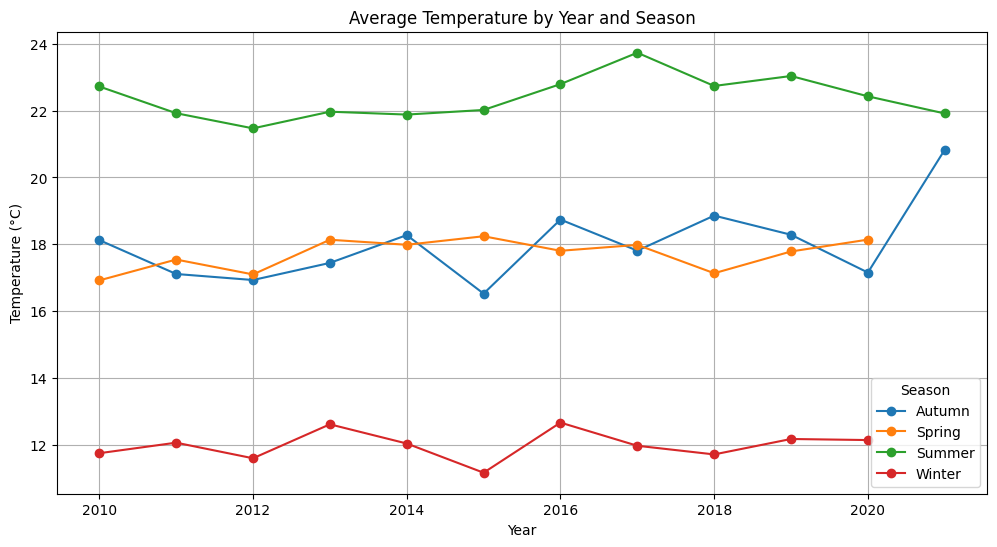

In [161]:
# Group by Year and Season and calculate the mean for each group
seasonal_yearly_means = merged_df.groupby(['Year', 'Season']).mean()

# Visualize the average demand and temperature year by year for each season
# Plot for Total Demand
seasonal_yearly_means.unstack(level=1)['TOTALDEMAND'].plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Average Total Demand by Year and Season')
plt.ylabel('Total Demand (MW)')
plt.legend(title='Season')
plt.grid(True)
plt.show()

# Plot for Forecast Demand
seasonal_yearly_means.unstack(level=1)['FORECASTDEMAND'].plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Average Forecast Demand by Year and Season')
plt.ylabel('Forecast Demand (MW)')
plt.legend(title='Season')
plt.grid(True)
plt.show()

# Plot for Temperature
seasonal_yearly_means.unstack(level=1)['TEMPERATURE'].plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Average Temperature by Year and Season')
plt.ylabel('Temperature (°C)')
plt.legend(title='Season')
plt.grid(True)
plt.show()

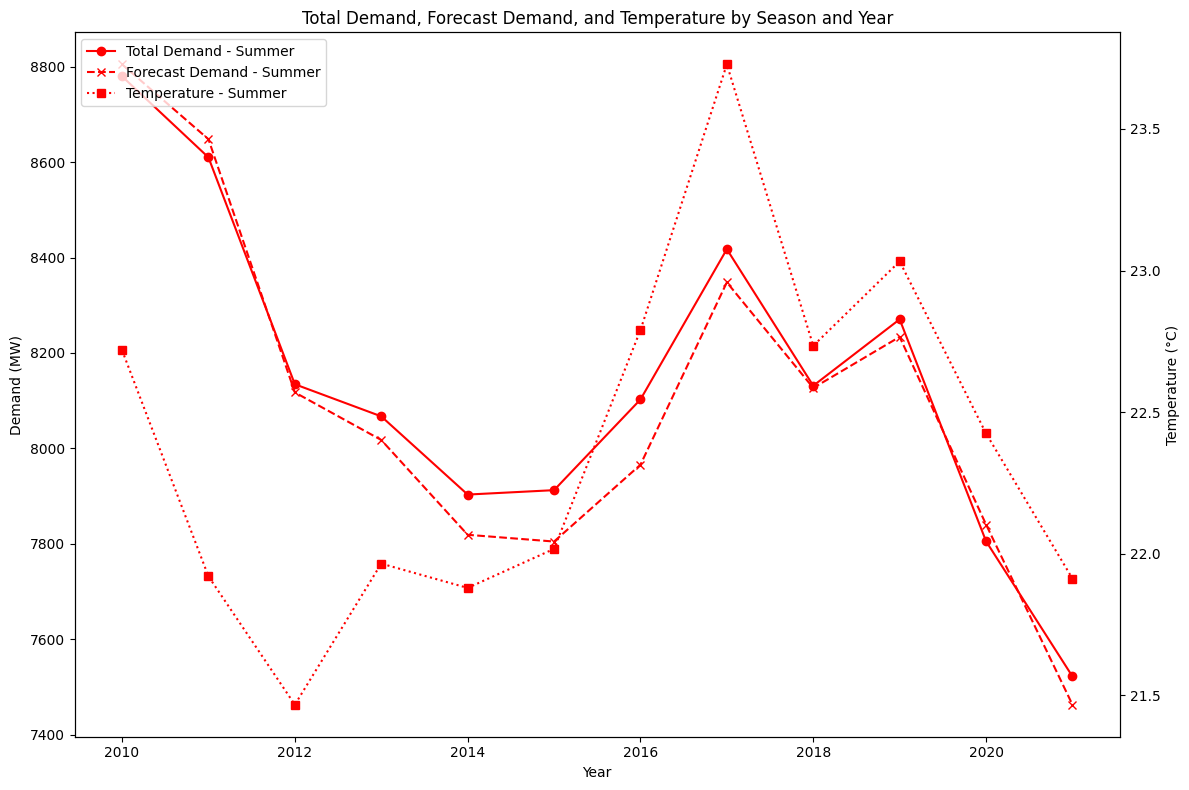

In [163]:
# Extract Year and Season from DATETIME
merged_df['Year'] = merged_df.index.year
merged_df['Season'] = merged_df.index.map(get_season)

# Group by both Year and Season and calculate the mean for each group
seasonal_yearly_means = merged_df.groupby(['Year', 'Season']).mean()

# Step 3: Unstack the multi-index dataframe for easier plotting
seasonal_yearly_means_unstacked = seasonal_yearly_means.unstack(level='Season')

# Define a color palette for the seasons
season_palette = {
    'Summer': 'red',
    'Autumn': 'orange',
    'Winter': 'blue',
    'Spring': 'green'
}

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot total demand and forecast demand on the left y-axis
for season in ['Summer']:
    ax1.plot(seasonal_yearly_means_unstacked.index,
             seasonal_yearly_means_unstacked['TOTALDEMAND'][season],
             label=f'Total Demand - {season}',
             color=season_palette[season], linestyle='-', marker='o')
    ax1.plot(seasonal_yearly_means_unstacked.index,
             seasonal_yearly_means_unstacked['FORECASTDEMAND'][season],
             label=f'Forecast Demand - {season}',
             color=season_palette[season], linestyle='--', marker='x')

# Set the labels and title for the left y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Demand (MW)')
ax1.set_title('Total Demand, Forecast Demand, and Temperature by Season and Year')

# Create the second y-axis for temperature
ax2 = ax1.twinx()

# Plot temperature on the right y-axis
for season in ['Summer']:
    ax2.plot(seasonal_yearly_means_unstacked.index,
             seasonal_yearly_means_unstacked['TEMPERATURE'][season],
             label=f'Temperature - {season}',
             color=season_palette[season], linestyle=':', marker='s')

# Set the label for the right y-axis
ax2.set_ylabel('Temperature (°C)')

# Combine the legends for both y-axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

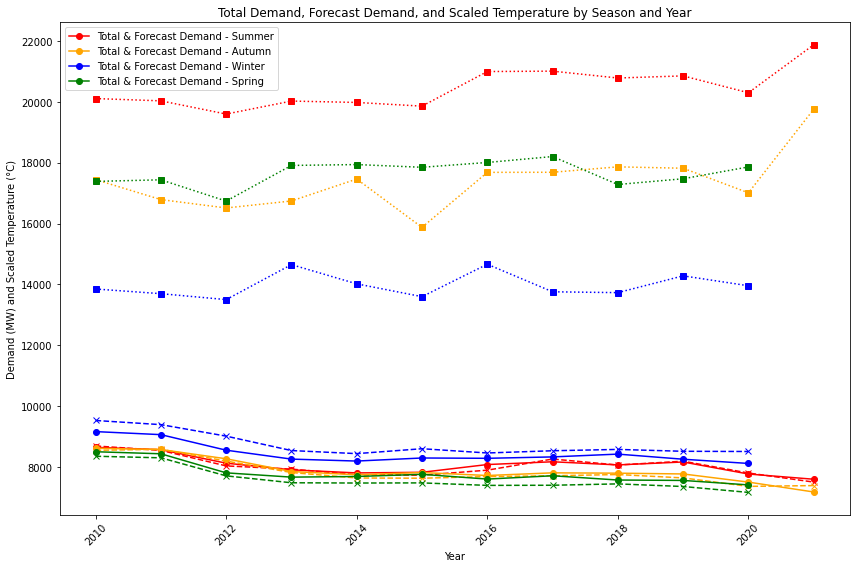

In [ ]:
#  Extract Year and Season from DATETIME
merged_df['Year'] = merged_df.index.year
merged_df['Season'] = merged_df.index.map(get_season)

#  Group by both Year and Season and calculate the mean for each group
seasonal_yearly_means = merged_df.groupby(['Year', 'Season']).mean()

# Unstack the multi-index dataframe for easier plotting
seasonal_yearly_means_unstacked = seasonal_yearly_means.unstack(level='Season')

# Define a color palette for the seasons
season_palette = {
    'Summer': 'red',
    'Autumn': 'orange',
    'Winter': 'blue',
    'Spring': 'green'
}

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot all variables for each season with one line per season
for season in ['Summer', 'Autumn', 'Winter', 'Spring']:
    # Normalize temperature to the scale of demand for easier comparison
    temp_scaled = seasonal_yearly_means_unstacked['TEMPERATURE'][season] * 1000  # Scale temperature
    ax1.plot(seasonal_yearly_means_unstacked.index,
             seasonal_yearly_means_unstacked['TOTALDEMAND'][season],
             label=f'Total & Forecast Demand - {season}',
             color=season_palette[season], linestyle='-', marker='o')

    ax1.plot(seasonal_yearly_means_unstacked.index,
             seasonal_yearly_means_unstacked['FORECASTDEMAND'][season],
             color=season_palette[season], linestyle='--', marker='x')

    ax1.plot(seasonal_yearly_means_unstacked.index,
             temp_scaled,
             color=season_palette[season], linestyle=':', marker='s')

# Set the labels and title for the left y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Demand (MW) and Scaled Temperature (°C)')
ax1.set_title('Total Demand, Forecast Demand, and Scaled Temperature by Season and Year')

# Combine the legend into one
ax1.legend(loc='upper left')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()